In [1]:
import warnings; warnings.simplefilter('ignore')

import hotspot
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sparse

from sklearn.decomposition import PCA
from umap import UMAP

import scanpy as sc
from anndata import read_h5ad

import scTRS.util as util
import scTRS.method as md
import scTRS.data_loader as dl
from os.path import join

# constants
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
SCORE_FILE_DIR = join(DATA_PATH, "score_file")

# loading the relevant files
df_obs_dict = dict()
for dataset in ["tms_facs", "tms_droplet"]:
    if dataset == 'tms_facs':
        file_name = join(DATA_PATH, 'tabula_muris_senis/tabula-muris-senis-facs-official-raw-obj.h5ad')
    elif dataset == 'tms_droplet':
        file_name = join(DATA_PATH, 'tabula_muris_senis/tabula-muris-senis-droplet-official-raw-obj.h5ad')
    df_obs_dict[dataset] = read_h5ad(file_name).obs.copy()

TRAIT_LIST = ["PASS_HDL", "PASS_LDL", "PASS_Alzheimers_Jansen2019", "PASS_Rheumatoid_Arthritis"]

# read scores
score_df_dict = dict()
for dataset in ["tms_facs", "tms_droplet"]:
    df_obs = df_obs_dict[dataset]
    df_obs["tissue.ct"] = df_obs["tissue"].astype(str) + '.' + df_obs["cell_ontology_class"].astype(str)
    if dataset == "tms_facs":
        score_dir = join(SCORE_FILE_DIR, "score.tms_facs.gwas_max_abs_z.top500")
    elif dataset == "tms_droplet":
        score_dir = join(SCORE_FILE_DIR, "score.tms_droplet.gwas_max_abs_z.top500.weight_1en2")
    elif dataset == "liver_atlas":
        score_dir = join(SCORE_FILE_DIR, "score.liver_atlas.gwas_max_abs_z.top500")
    else:
        raise NotImplementedError
        
    for trait in TRAIT_LIST:
        score_df = pd.read_csv(join(score_dir, f"{trait}.score.gz"), sep='\t', index_col=0)
        score_df_dict[f"{trait}@{dataset}"] = score_df

In [2]:
# filter for GWAS genes
GS_FILE = "/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs"
df_gs = pd.read_csv(GS_FILE, sep='\t')
df_gs.index = df_gs['TRAIT']

df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                             'mouse_human_homologs.txt', sep='\t')

dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}

for trait in df_gs.index:
    human_gene_list = df_gs.loc[trait, 'GENESET'].split(',')
    mouse_gene_list = [dic_map[x] for x in set(human_gene_list)&set(dic_map.keys())]
    df_gs.loc[trait, 'GENESET'] = ','.join(mouse_gene_list)

In [3]:
tissue = "Liver"
dataset = "tms_facs"
adata = dl.load_tms_processed(DATA_PATH, data_name=dataset.split('_')[1], tissue=tissue)[tissue]
adata.X = adata.raw.X
adata.layers["counts"] = adata.X.copy()
# adata = adata[adata.obs.cell_ontology_class == "hepatocyte"].copy()
# trait = "PASS_LDL"
# trait = "PASS_Alzheimers_Jansen2019"
# gwas_gene_list = df_gs.loc[trait, "GENESET"].split(',')
# adata = adata[:, adata.var_names.isin(gwas_gene_list)]
# adata = adata[adata.obs.cell_ontology_class == "hepatocyte"].copy()

# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


In [4]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

In [5]:
N_COMP = 10
pca_data = pd.DataFrame(adata.obsm["X_pca"][:, :N_COMP], index=adata.obs_names)

# counts
counts = pd.DataFrame(adata.layers["counts"].todense().T, index=adata.var_names, columns=adata.obs_names)
hs = hotspot.Hotspot(counts, model='danb', latent=pca_data, umi_counts=counts.sum(axis=0))

# normalized counts
# values = pd.DataFrame(adata.X.T, index=adata.var_names, columns=adata.obs_names)
# hs = hotspot.Hotspot(values, model='normal', latent=pca_data)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

In [6]:
hs_results = hs.compute_autocorrelations(jobs=4)

hs_results.head(15)

100%|██████████| 4453/4453 [00:03<00:00, 1199.67it/s]


,C,Z,Pval,FDR
Gene,,,,
Cyp2b9,0.312543,1037.108914,0.0,0.0
Cyp2c69,0.652198,861.143832,0.0,0.0
Cyp2c40,0.579112,841.855707,0.0,0.0
Fmo3,0.225656,800.625719,0.0,0.0
A1bg,0.733923,779.151810,0.0,0.0
Cyp2a4,0.356401,714.098397,0.0,0.0
Wfdc1,0.095026,706.892476,0.0,0.0
Lars2,0.100041,700.688308,0.0,0.0
Slc22a26,0.171316,665.897387,0.0,0.0


In [7]:
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(500).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=4)

100%|██████████| 500/500 [00:00<00:00, 8217.07it/s]


Computing pair-wise local correlation on 500 features...


100%|██████████| 124750/124750 [00:34<00:00, 3594.71it/s]


In [8]:
modules = hs.create_modules(
    min_gene_threshold=15, core_only=True, fdr_threshold=0.05
)

modules.value_counts()

 1     129
 2      51
 9      48
 3      46
 7      39
 6      36
 5      36
 4      34
 10     25
-1      21
 8      20
 11     15
Name: Module, dtype: int64

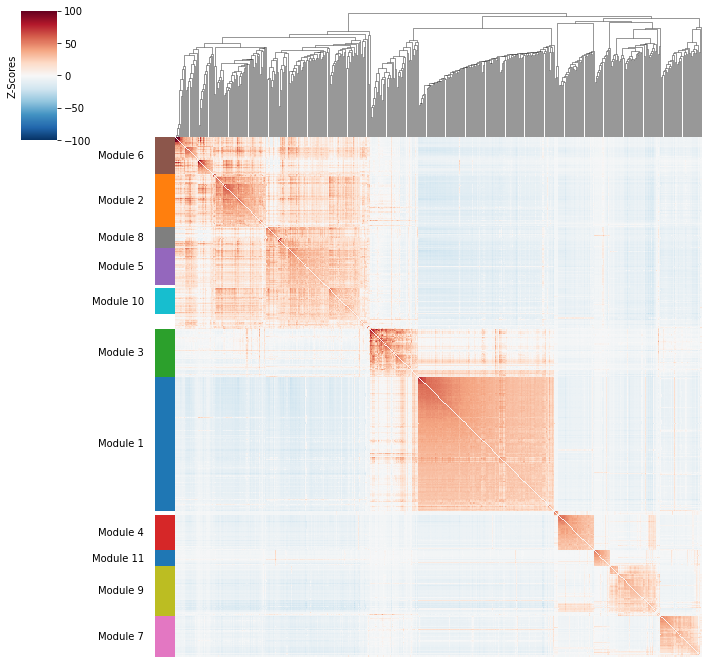

In [9]:
hs.plot_local_correlations(vmin=-100, vmax=100)

  0%|          | 0/11 [00:00<?, ?it/s]

Computing scores for 11 modules...


100%|██████████| 11/11 [00:00<00:00, 22.50it/s]


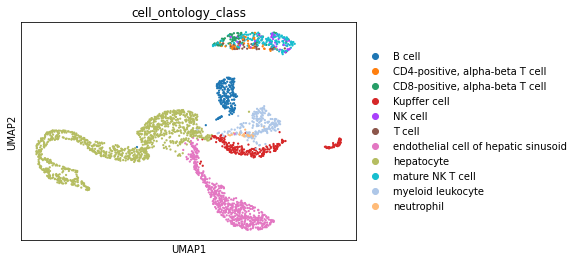

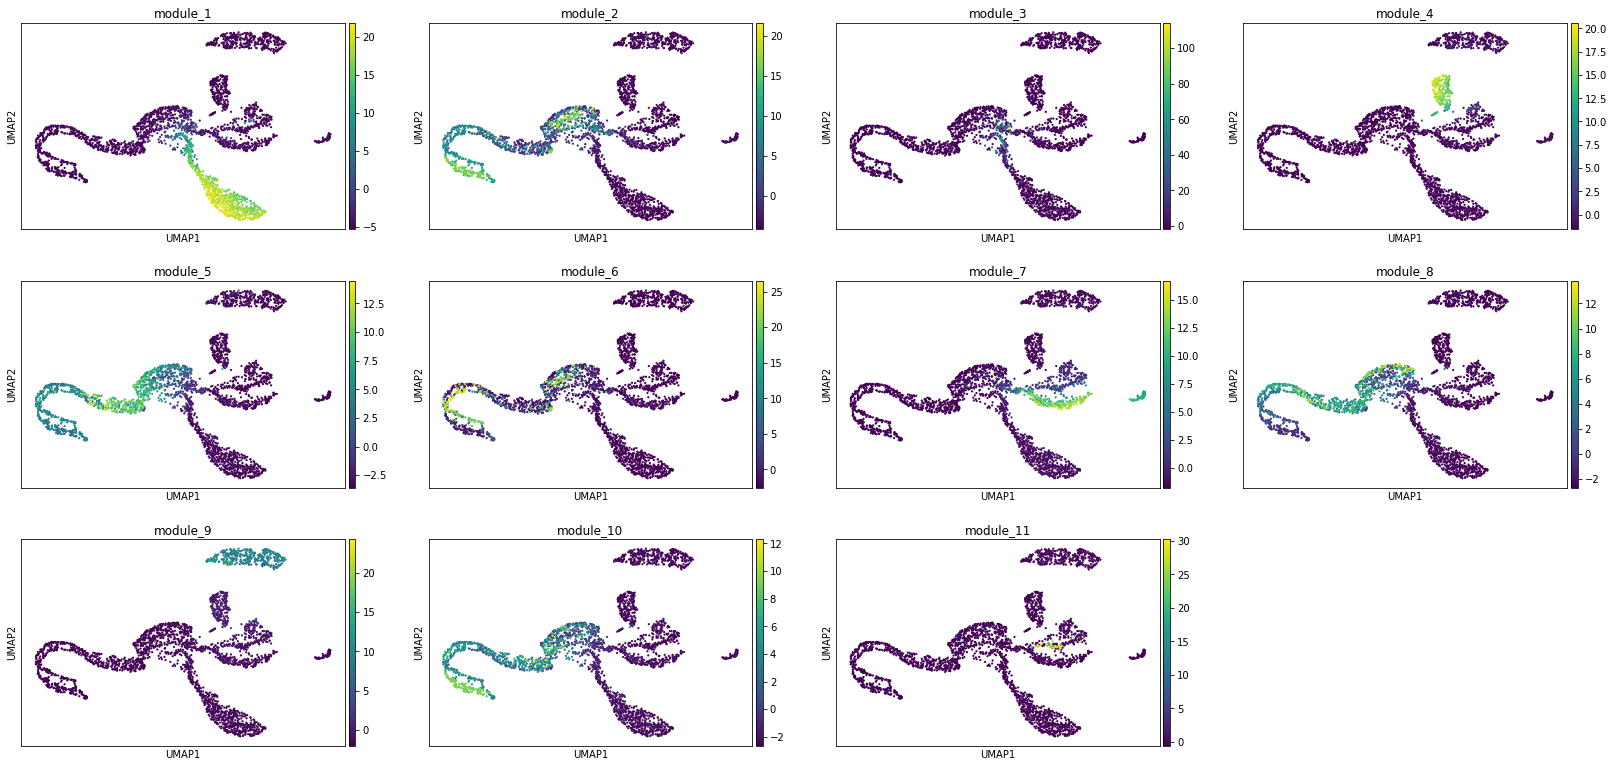

In [10]:
module_scores = hs.calculate_module_scores()
module_scores.head()

sc.pl.umap(adata, color=["cell_ontology_class"], size=20, ncols=1)
for module_i in hs.module_scores.columns:
    adata.obs[f"module_{module_i}"] = hs.module_scores[module_i].reindex(adata.obs.index)
sc.pl.umap(adata, color=[f"module_{module_i}" for module_i in hs.module_scores.columns], size=20, ncols=4)